# Examples 
## [Australian Tourism Hierarchy](https://otexts.com/fpp2/hts.html)

In this showcase we are going to use Australian Tourism data that shows number of visitors in Australian in a quarterly period from 1998 to 2016. This is exactly the same data Hyndman uses in his book with a little modification that first we transformed it to a long format because we think most datasets are storaged in this way, so we will do a step by step demonstration of how we treat our data before fitting any model.

In [1]:
# Usual imports
import sys

sys.path.append("../src")

import os
from pprint import pprint
import importlib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Download the raw files into this directory
data = '../data/raw/'

# helper functions
from visualize import get_nodes_edges_position, make_annotations

sns.set_context("poster")

/home/v086200/anaconda3/envs/m5/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Loading Data

In [3]:
DATAPATH = os.path.join(data, "visnights")
os.listdir(DATAPATH)

['visnights.csv']

In [4]:
visnights = pd.read_csv(os.path.join(DATAPATH, "visnights.csv"))
visnights.head(7)

date state   zone  total_visitors_nights
0  1998-01-01   NSW  Metro            9047.095397
1  1998-04-01   NSW  Metro            6962.125890
2  1998-07-01   NSW  Metro            6871.963047
3  1998-10-01   NSW  Metro            7147.292612
4  1999-01-01   NSW  Metro            7956.922814
5  1999-04-01   NSW  Metro            6542.243263
6  1999-07-01   NSW  Metro            6330.364078

The hierarchy in this dataset is the following:
 - six geographic areas (NSW, QLD, SAU, VIC, WAU, OTH)
 - each geographic area can have a different number of zones, for example, NSW has five.
 
So in order to produce unique bottom series, let's create a new column where we concatenate state and zone.

In [5]:
visnights["state_zone"] = visnights.apply(lambda x: f"{x['state']}_{x['zone']}", axis=1)

### Visualizing Tree Structure

Let's create a simple plot of our tree structure so we can develop a better understanding of our dataset. We will use networkx and plotly to produce the visualization, so we need to create a list of tuples for each connection.

In [6]:
grouped_sections = visnights.groupby(["state", "state_zone"])
edges_hierarchy = list(grouped_sections.groups.keys())
edges_hierarchy[:7]

[('NSW', 'NSW_Metro'),
 ('NSW', 'NSW_NthCo'),
 ('NSW', 'NSW_NthIn'),
 ('NSW', 'NSW_SthCo'),
 ('NSW', 'NSW_SthIn'),
 ('OTH', 'OTH_Metro'),
 ('OTH', 'OTH_NoMet')]

Now, we must not forget total that is our root node.

In [7]:
second_level_nodes = ["NSW", "OTH", "WAU", "SAU", "QLD", "VIC"]
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges

[('total', 'NSW'),
 ('total', 'OTH'),
 ('total', 'WAU'),
 ('total', 'SAU'),
 ('total', 'QLD'),
 ('total', 'VIC')]

In [8]:
root_edges += edges_hierarchy

In [9]:
Xn, Yn, Xe, Ye, labels, annot = get_nodes_edges_position(root_edges, root="total")
M = max(Yn)

fig = go.Figure()

fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=30,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Hierarchical Structure Tree for Australian Tourism Data',
              annotations=annot,
              font_size=10,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

We can see above how our data is structured, now let's transform it in order to use scikit-hts properly.

### Transform data in the format required by scikit-hts

*scikit-hts* requires that each column in our DataFrame is a time series of its own, for all hierarchy levels. Let's do that. Remember that our data is in a long format.

The steps are the following:

1. Transform dataset into a column oriented one
2. Create the hierarchy representation as a dictionary
 
For a complete description of how that is done under the hood, and for a sense of what the API accepts, see [scikit-hts' docs](https://scikit-hts.readthedocs.io/en/latest/hierarchy.html)

In [18]:
visnights_bottom_level = visnights.pivot(index="date", columns="state_zone", values="total_visitors_nights")
visnights_bottom_level.head(5)

state_zone    NSW_Metro    NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
date                                                                          
1998-01-01  9047.095397  8565.677890  2977.506662  5818.028804  2679.537963   
1998-04-01  6962.125890  7124.468362  3477.702717  2466.436706  3010.732155   
1998-07-01  6871.963047  4716.893116  3014.770331  1928.052834  3328.869005   
1998-10-01  7147.292612  6269.299065  3757.972112  2797.555974  2417.772236   
1999-01-01  7956.922814  9493.901336  3790.759900  4853.680680  3224.285428   

state_zone    OTH_Metro    OTH_NoMet    QLD_Cntrl     QLD_Metro    QLD_NthCo  \
date                                                                           
1998-01-01  3437.923945  2073.469372  2748.373689  12106.052376  2137.234012   
1998-04-01  2677.081107  1787.938519  4040.915256   7786.686688  2269.595619   
1998-07-01  3793.742887  2345.020634  5343.964347  11380.023616  4890.227020   
1998-10-01  3304.231082  1943.688721  4260.418878   9311.460272  2621.548165   
1999-01-01  3510.818728  2165.837870  4186.113263  12671.941529  2483.202540   

state_zone    SAU_Coast    SAU_Inner    SAU_Metro    VIC_EstCo    VIC_Inner  \
date                                                                          
1998-01-01  2591.997218   894.877294  2881.371786  3381.972183  5326.655137   
1998-04-01  1375.780128   979.250884  2124.735577  1827.940100  4441.118574   
1998-07-01  1079.541542   980.328853  2284.870236  1351.952120  3815.645302   
1998-10-01  1497.663951  1509.434264  1785.888968  1493.414796  3859.567145   
1999-01-01  2247.683952   963.522662  2293.872588  2896.928893  4588.755209   

state_zone    VIC_Metro    VIC_WstCo    WAU_Coast    WAU_Inner    WAU_Metro  
date                                                                         
1998-01-01  7490.381649  2442.004813  3066.555070   694.995372  3075.778941  
1998-04-01  5198.178082   960.504703  3334.405408   557.679575  2154.928814  
1998-07-01  5244.217363   755.974380  4365.844091  1006.184417  2787.286174  
1998-10-01  6274.245607  1271.603970  4521.995729  1172.551447  2752.909841  
1999-01-01  9187.421553  2385.058308  3579.346592   398.182909  3519.564374

We still need data aggregate by state and the total column.

In [19]:
def get_state_columns(df, state):
    return [col for col in df.columns if state in col]

states = visnights["state"].unique().tolist()

for state in states:
    state_cols = get_state_columns(visnights_bottom_level, state)
    visnights_bottom_level[state] = visnights_bottom_level[state_cols].sum(axis=1)

visnights_bottom_level["total"] = visnights_bottom_level[states].sum(axis=1)

visnights_bottom_level.head(5)

state_zone    NSW_Metro    NSW_NthCo    NSW_NthIn    NSW_SthCo    NSW_SthIn  \
date                                                                          
1998-01-01  9047.095397  8565.677890  2977.506662  5818.028804  2679.537963   
1998-04-01  6962.125890  7124.468362  3477.702717  2466.436706  3010.732155   
1998-07-01  6871.963047  4716.893116  3014.770331  1928.052834  3328.869005   
1998-10-01  7147.292612  6269.299065  3757.972112  2797.555974  2417.772236   
1999-01-01  7956.922814  9493.901336  3790.759900  4853.680680  3224.285428   

state_zone    OTH_Metro    OTH_NoMet    QLD_Cntrl     QLD_Metro    QLD_NthCo  \
date                                                                           
1998-01-01  3437.923945  2073.469372  2748.373689  12106.052376  2137.234012   
1998-04-01  2677.081107  1787.938519  4040.915256   7786.686688  2269.595619   
1998-07-01  3793.742887  2345.020634  5343.964347  11380.023616  4890.227020   
1998-10-01  3304.231082  1943.688721  4260.418878   9311.460272  2621.548165   
1999-01-01  3510.818728  2165.837870  4186.113263  12671.941529  2483.202540   

state_zone  ...    WAU_Coast    WAU_Inner    WAU_Metro           NSW  \
date        ...                                                        
1998-01-01  ...  3066.555070   694.995372  3075.778941  29087.846716   
1998-04-01  ...  3334.405408   557.679575  2154.928814  23041.465829   
1998-07-01  ...  4365.844091  1006.184417  2787.286174  19860.548333   
1998-10-01  ...  4521.995729  1172.551447  2752.909841  22389.891997   
1999-01-01  ...  3579.346592   398.182909  3519.564374  29319.550158   

state_zone           QLD          SAU           VIC          WAU          OTH  \
date                                                                            
1998-01-01  16991.660077  6368.246298  18641.013782  6837.329383  5511.393317   
1998-04-01  14097.197563  4479.766589  12427.741460  6047.013796  4465.019627   
1998-07-01  21614.214983  4344.740630  11167.789164  8159.314681  6138.763522   
1998-10-01  16193.427315  4792.987183  12898.831518  8447.457017  5247.919803   
1999-01-01  19341.257332  5505.079202  19058.163963  7497.093876  5676.656598   

state_zone         total  
date                      
1998-01-01  83437.489573  
1998-04-01  64558.204863  
1998-07-01  71285.371313  
1998-10-01  69970.514833  
1999-01-01  86397.801129  

[5 rows x 27 columns]

Now that we have our dataset ready, let's define our hierarchy tree. We need a dictionary, where each key is a column (node) in our hierarchy and a list of its children.

In [20]:
hierarchy = dict()

for edge in root_edges:
    parent, children = edge[0], edge[1]
    hierarchy.get(parent)
    if not hierarchy.get(parent):
        hierarchy[parent] = [children]
    else:
        hierarchy[parent] += [children]

In [21]:
hierarchy

{'total': ['NSW', 'OTH', 'WAU', 'SAU', 'QLD', 'VIC'],
 'NSW': ['NSW_Metro', 'NSW_NthCo', 'NSW_NthIn', 'NSW_SthCo', 'NSW_SthIn'],
 'OTH': ['OTH_Metro', 'OTH_NoMet'],
 'QLD': ['QLD_Cntrl', 'QLD_Metro', 'QLD_NthCo'],
 'SAU': ['SAU_Coast', 'SAU_Inner', 'SAU_Metro'],
 'VIC': ['VIC_EstCo', 'VIC_Inner', 'VIC_Metro', 'VIC_WstCo'],
 'WAU': ['WAU_Coast', 'WAU_Inner', 'WAU_Metro']}

### Fitting our models

Let's fit a few different models in our data and compare results.

In [22]:
# Does not change anything in data, except for index to be QS
visnights_bottom_level.index = pd.to_datetime(visnights_bottom_level.index)
visnights_bottom_level = visnights_bottom_level.resample("QS").sum()

#### Auto-Arima

First let's use scikit-hts to fit an ARIMA model specifically, the auto-arima implemented in the excellent pmdarima library.

In [23]:
from hts import HTSRegressor

clf = HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model = clf.fit(visnights_bottom_level, hierarchy)

Folium not installed, not all visualization will work
h3-py must be installed for geo hashing capabilities
Mapping requires folium==0.10.0 to be installed, geo mapping will not work
h3-py must be installed for geo hashing capabilities
Fitting models: 100%|██████████| 27/27 [00:44<00:00,  1.66s/it]


Now we can predict results for each node.

In [24]:
predicted_autoarima = model.predict(steps_ahead=8)

Fitting models: 100%|██████████| 27/27 [00:00<00:00, 182.83it/s]


Let's visualize the model results and fitted values for all states.

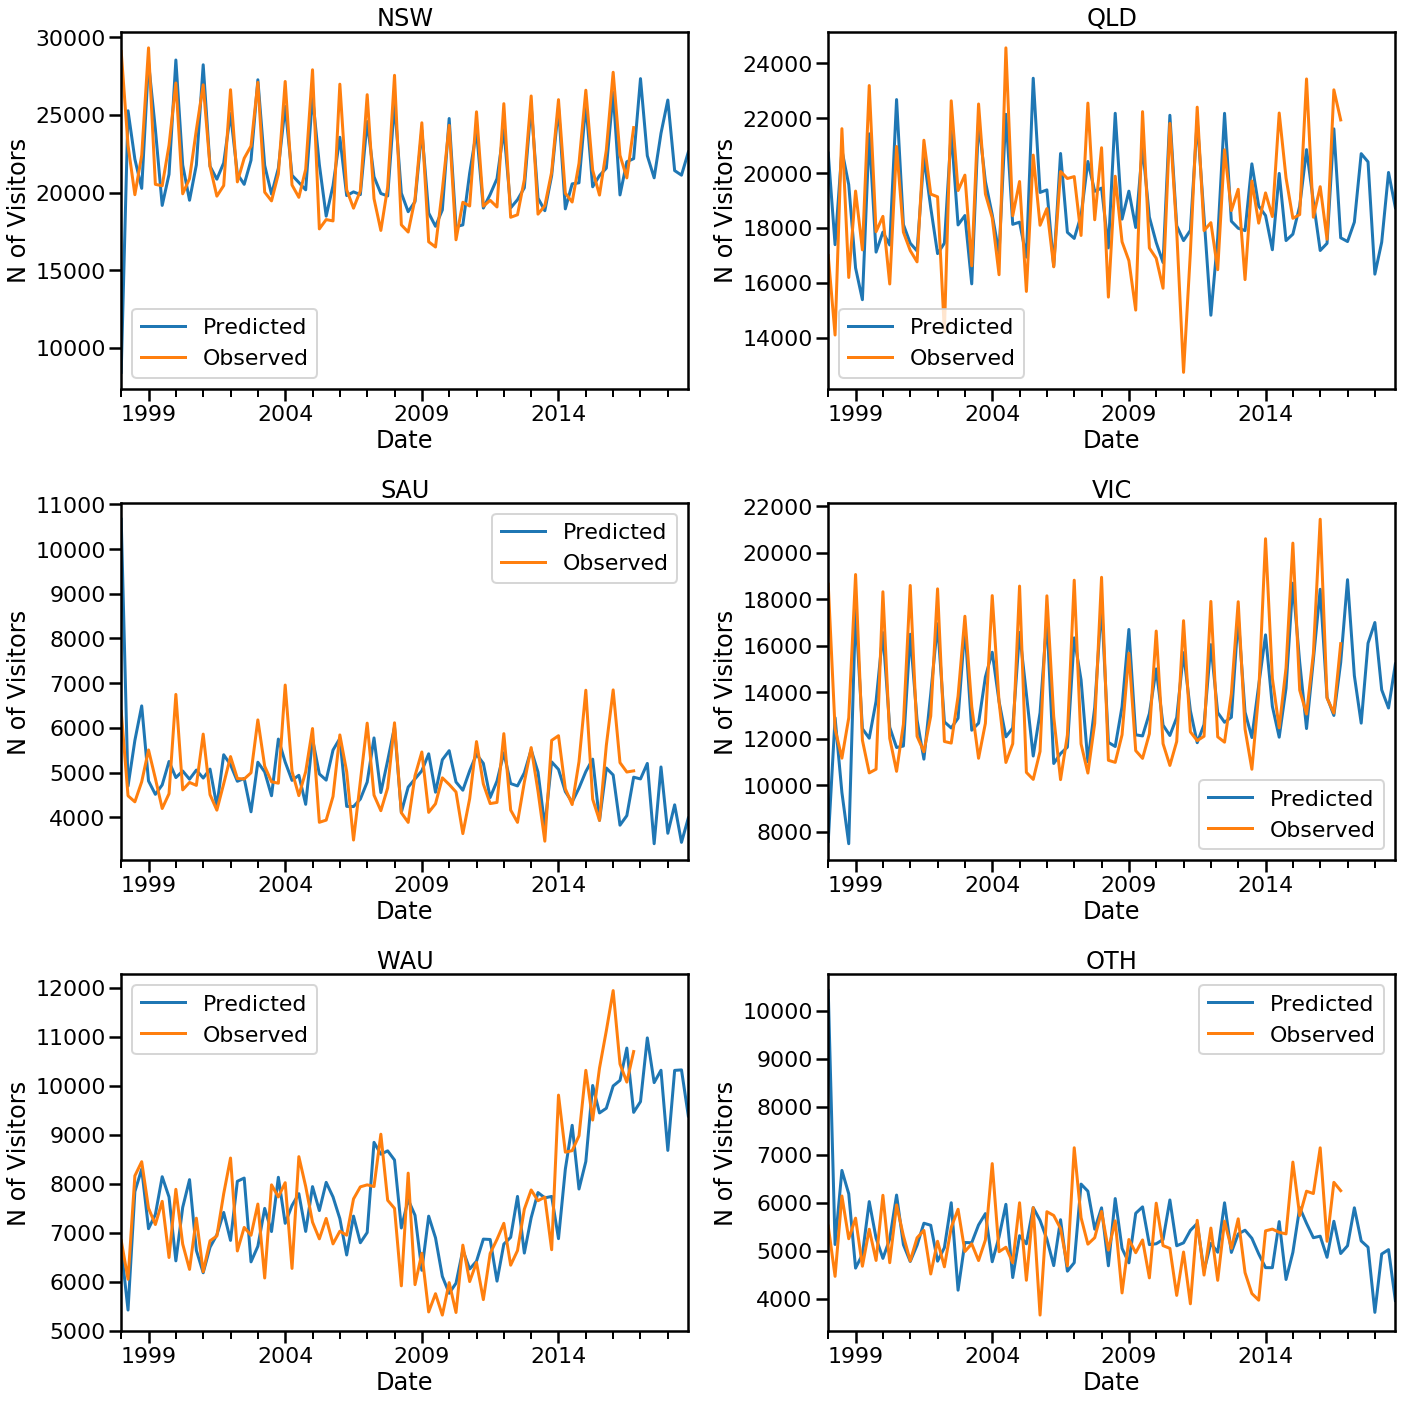

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        visnights_bottom_level[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("N of Visitors")
    
plot_results(states, axes, predicted_autoarima)
plt.tight_layout()

Of course, you can also check results for specific, nodes, let's get for OTH:

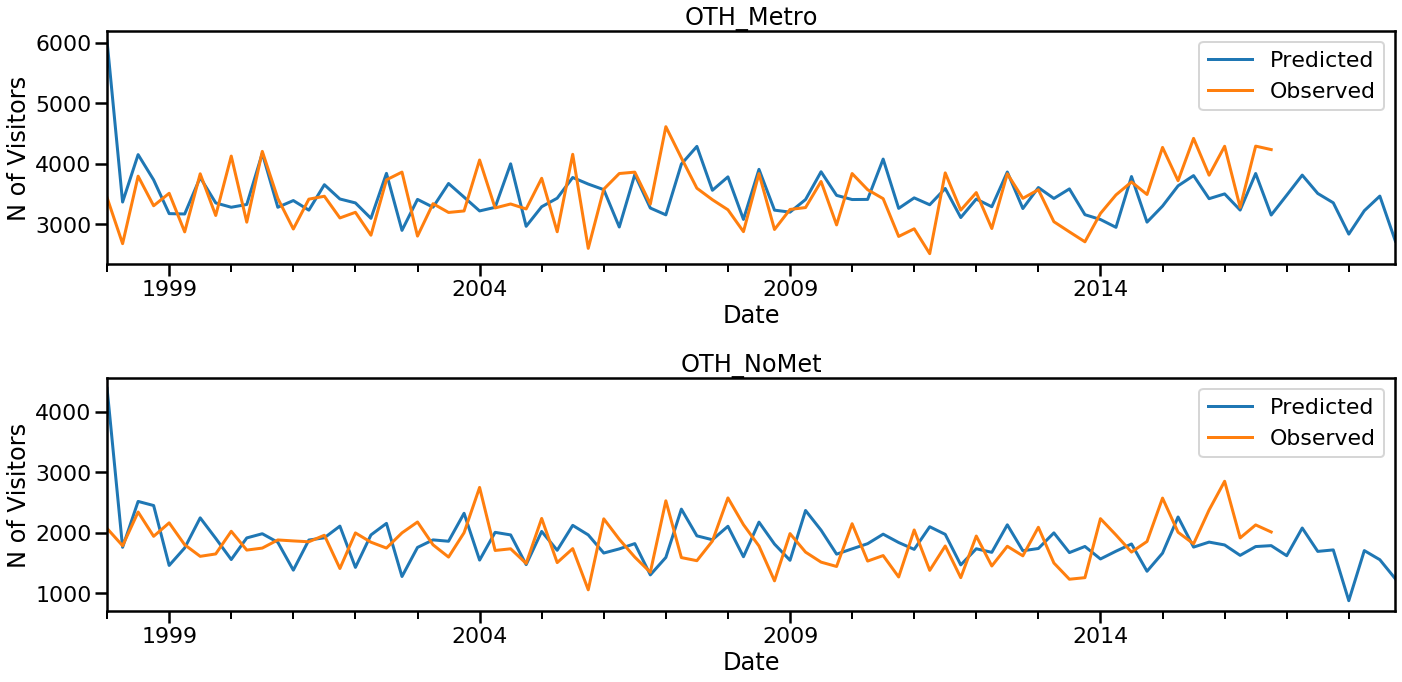

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
plot_results(state_cols, axes, predicted_autoarima)
plt.tight_layout()

#### Prophet

We can do the same fit as above, but now for prophet model.

In [27]:
clf = HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model = clf.fit(visnights_bottom_level, hierarchy)

Fitting models: 100%|██████████| 27/27 [00:17<00:00,  1.51it/s]


In [28]:
predicted_prophet = model.predict(steps_ahead=8)

Fitting models: 100%|██████████| 27/27 [00:34<00:00,  1.27s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fde09e1f290>


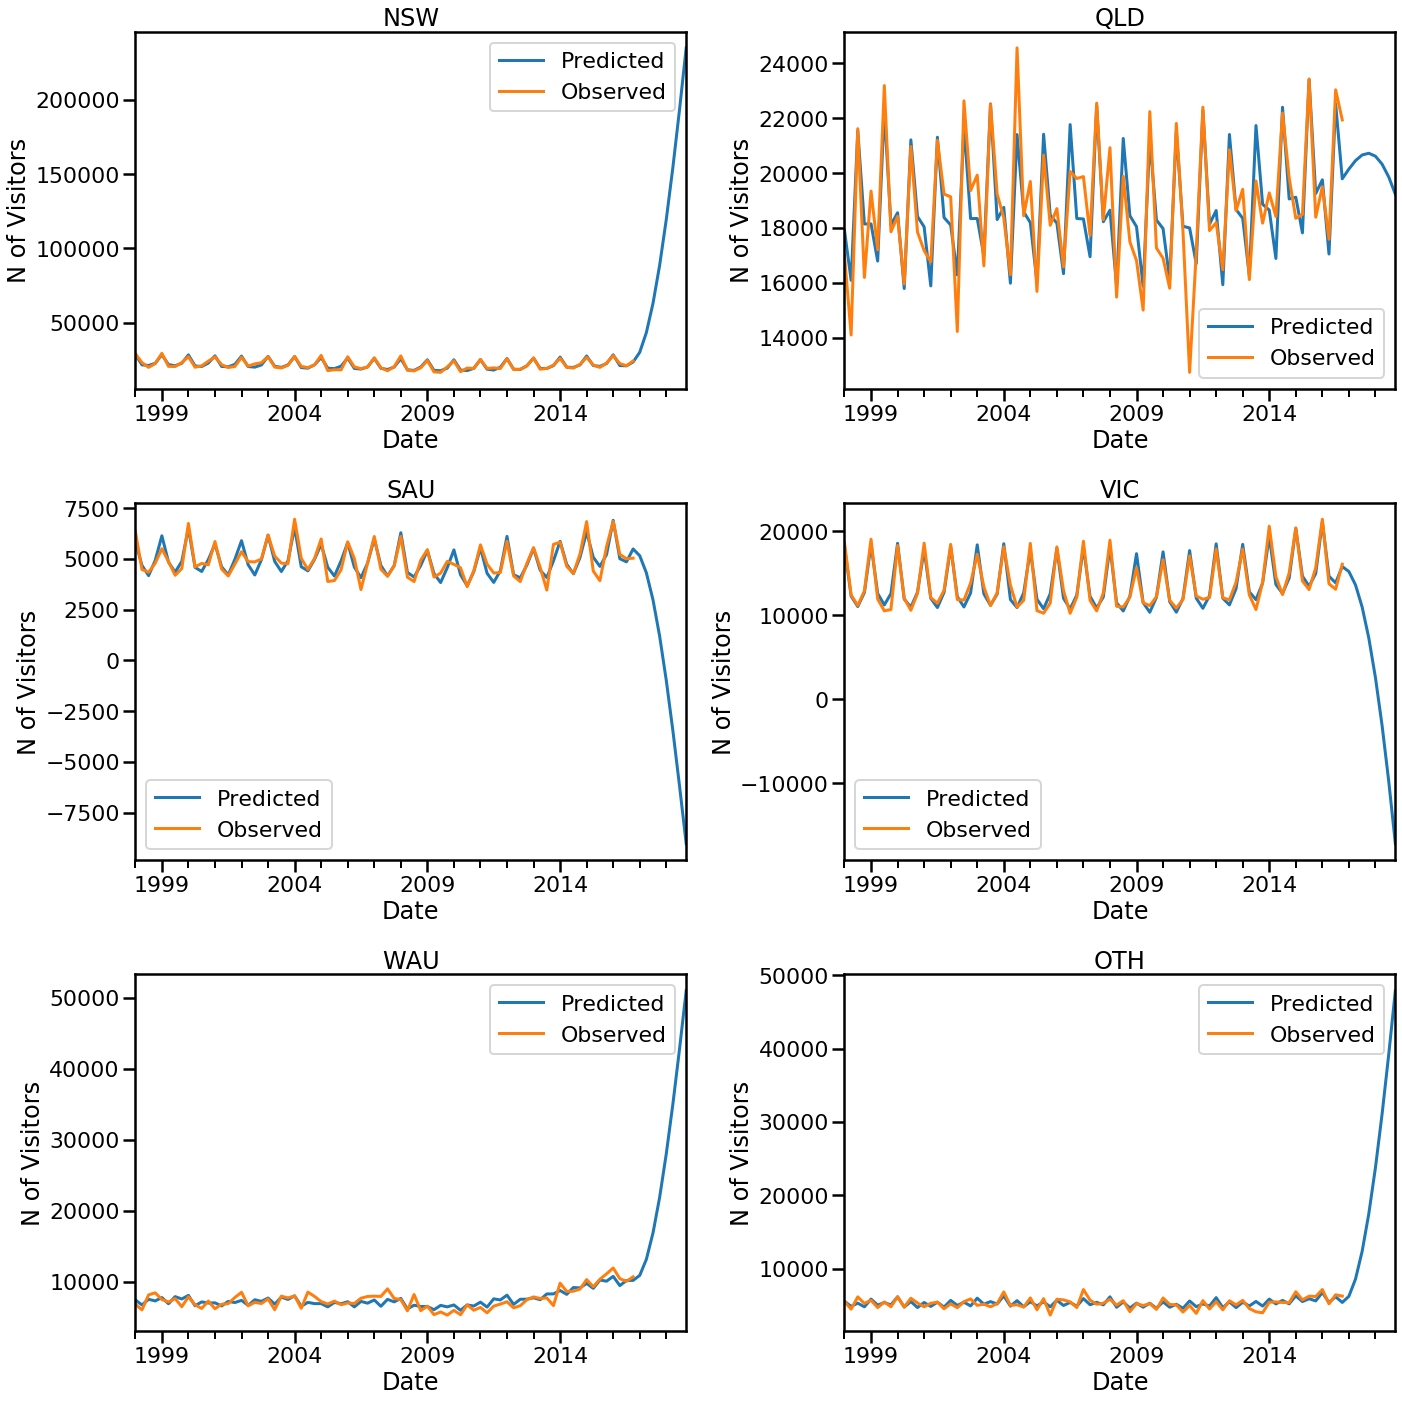

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
plot_results(states, axes, predicted_prophet)
plt.tight_layout()